In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

In [2]:
def plot(sensor_data, col_name, headLabel, gesture):
    fig, ax1 = plt.subplots(figsize=(16, 3))

    ax1.plot(range(len(sensor_data)), headLabel)
    ax1.set_ylabel('HeadLabel')

    ax2 = ax1.twinx()
    ax2.plot(range(len(sensor_data)), sensor_data, color='red')
    ax2.set_ylabel(col_name)
    # ax1.set_xlim([0, 40])
#     ax1.set_xticks(np.arange(0, len(data), 10))
    plt.title('{} V.S. {}'.format(col_name, gesture))

In [3]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return np.r_[a[0:n-1], ret[n - 1:] / n]

label_map = {'only': 0, 'down': 1, 'up': 2, 'left': 3, 'right': 4, 
             'leftLean': 5, 'rightLean': 6, 'leftRoll': 7, 'rightRoll': 8}
inverse_label_map = {0:'only', 1:'down', 2:'up', 3:'left', 4:'right', 
             5:'leftLean', 6:'rightLean', 7:'leftRoll', 8:'rightRoll'}
sensor_names = ['AccX', 'AccY', 'AccZ', 'GyoX', 'GyoY', 'GyoZ']

class HeadDataset(Dataset):
    def __init__(self, root_dir, window_size=16):
        _, _, files = list(os.walk(root_dir))[0]
        data_list = []
        new_head_label = 'headLabel'
        length_list = []
        for file in files:
            data = pd.read_csv(os.path.join(root_dir, file))
            name = file.split('_')[1].split('.')[0]
            col_name = 'is' + name[0].upper() + name[1:]
            data[new_head_label] = data[col_name].astype(int) * label_map[name]
            for sensor in sensor_names:
                data[sensor] = moving_average(data[sensor].values)
                
            data_list.append(data)
            length_list.append(self.get_each_length(data, window_size))
            
        length_list = np.cumsum(length_list)
        self.data_list = data_list
        self.length_list = length_list
        self.length = length_list[-1]
        self.window_size = window_size
        self.n = len(data_list)

    def get_each_length(self, data, window_size):
        return len(data) - window_size + 1
    
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        if idx > self.length - 1: raise Exception('index is too big!')
            
        for i in range(-1, self.n-1):
            if idx < self.length_list[i+1]:
                if i == -1: data_idx = idx
                else: data_idx = idx - self.length_list[i]
                data = self.data_list[i+1]
                break

        subsequence = data[data_idx:data_idx + self.window_size]
        return {'inputs': torch.from_numpy(subsequence[sensor_names].values.T), 
                'isWalk': torch.from_numpy(subsequence['isWalk'].values),
                'headLabel': torch.from_numpy(subsequence['headLabel'].values)}
    
datasets = {x: HeadDataset('labeled_data/{}'.format(x)) for x in ['train', 'test']}

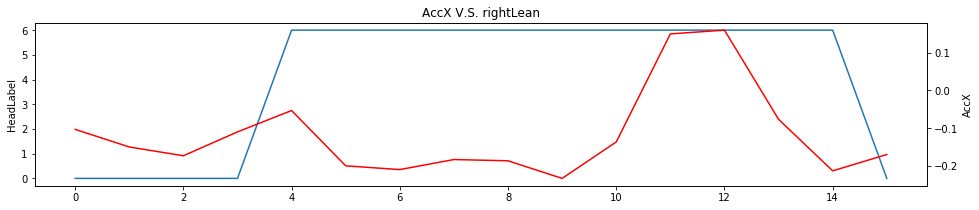

In [4]:
idx = 200
sample = datasets['train'][idx]
AccX = sample['inputs'][0, :].numpy()
headLabel = sample['headLabel'].numpy()
gesture = inverse_label_map[headLabel.max()]
plot(AccX, 'AccX', headLabel, gesture)

In [5]:
print(datasets['train'][279]['inputs'].shape)
print(datasets['train'][279]['isWalk'].shape)
print(datasets['train'][279]['headLabel'].shape)

torch.Size([6, 16])
torch.Size([16])
torch.Size([16])


In [6]:
print(len(datasets['train']))
for i in range(len(datasets['train'])):
    s = datasets['train'][i]['inputs'].size()[1]
    if s == 0: print(i)

3122


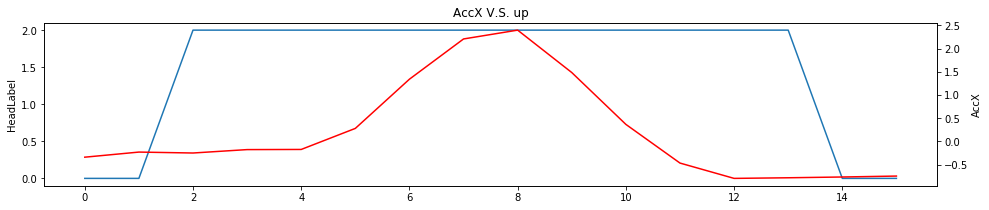

In [7]:
idx = 148
sample = datasets['test'][idx]
AccX = sample['inputs'][0, :].numpy()
headLabel = sample['headLabel'].numpy()
gesture = inverse_label_map[headLabel.max()]
plot(AccX, 'AccX', headLabel, gesture)

In [8]:
len(datasets['train'])

3122

In [9]:
dataloaders = {
    x: DataLoader(datasets[x], batch_size=4, shuffle=True, num_workers=1) \
    for x in ['train', 'test']
}

# build a basic Dense Labeling model

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool1d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        self.up = nn.ConvTranspose1d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[1] - x1.size()[1]
        diffX = x2.size()[2] - x1.size()[2]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [11]:
# class DL(nn.Module):
#     def __init__(self, n_channels, n_classes):
#         super(DL, self).__init__()
#         self.n_channels = n_channels
#         self.n_classes = n_classes
# #         self.bilinear = bilinear

#         self.inc = DoubleConv(n_channels, 64)
#         self.down1 = Down(64, 128)
#         self.down2 = Down(128, 256)
#         self.down3 = Down(256, 512)
#         self.down4 = Down(512, 512)
#         self.up1 = Up(1024, 256)
#         self.up2 = Up(512, 128)
#         self.up3 = Up(256, 64)
#         self.up4 = Up(128, 64)
#         self.outc = OutConv(64, n_classes)

#     def forward(self, x):
#         x1 = self.inc(x)
# #         print('x1', x1.shape)
#         x2 = self.down1(x1)
# #         print('x2', x2.shape)
#         x3 = self.down2(x2)
# #         print('x3', x3.shape)
#         x4 = self.down3(x3)
# #         print('x4', x4.shape)
#         x5 = self.down4(x4)
# #         print('x5', x5.shape)
#         x = self.up1(x5, x4)
#         x = self.up2(x, x3)
#         x = self.up3(x, x2)
#         x = self.up4(x, x1)
#         logits = self.outc(x)
#         return logits

In [12]:
class DL(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(DL, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = DoubleConv(n_channels, 32)
        self.down1 = Down(32, 32)
        self.down2 = Down(32, 64)
        self.down3 = Down(64, 128)
        self.down4 = Down(128, 128)
        self.up1 = Up(256, 64)
        self.up2 = Up(128, 32)
        self.up3 = Up(64, 32)
        self.up4 = Up(64, 32)
        self.outc = OutConv(32, n_classes)


    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

epoch 9 epoch_loss 37.95481187105179 val_score 0.09301993995904922
headLabel_logits torch.Size([9, 16])
pred_label torch.Size([16])
pred_label [0 0 2 2 2 2 2 2 2 2 2 2 2 0 0 0]
epoch 19 epoch_loss 19.330591708421707 val_score 0.09085465222597122
headLabel_logits torch.Size([9, 16])
pred_label torch.Size([16])
pred_label [0 0 2 2 2 2 2 2 2 2 2 2 2 0 0 0]
epoch 29 epoch_loss 11.459601730108261 val_score 0.09095378965139389
headLabel_logits torch.Size([9, 16])
pred_label torch.Size([16])
pred_label [0 0 0 2 2 2 2 2 2 2 2 2 2 0 0 0]
epoch 39 epoch_loss 7.640854567289352 val_score 0.09091810137033463
headLabel_logits torch.Size([9, 16])
pred_label torch.Size([16])
pred_label [0 0 0 2 2 2 2 2 2 2 2 2 2 2 0 0]
epoch 49 epoch_loss 5.3805068507790565 val_score 0.09117984026670456
headLabel_logits torch.Size([9, 16])
pred_label torch.Size([16])
pred_label [0 0 0 2 2 2 2 2 2 2 2 2 2 2 0 0]
epoch 59 epoch_loss 4.212871756404638 val_score 0.09120362997055054
headLabel_logits torch.Size([9, 16])
pre

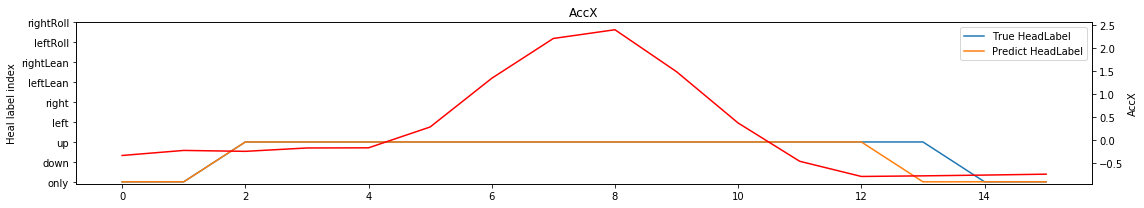

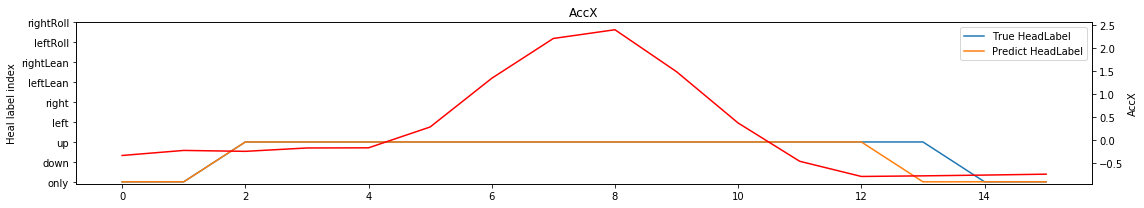

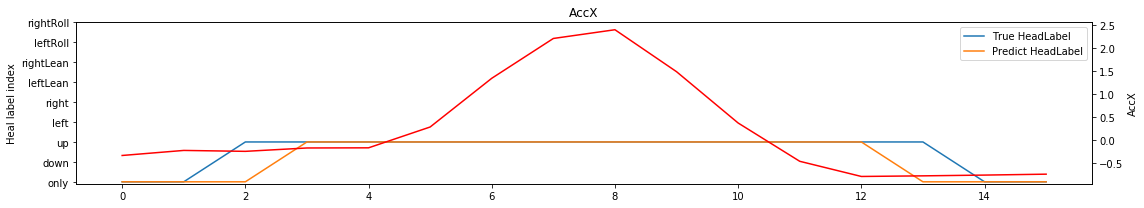

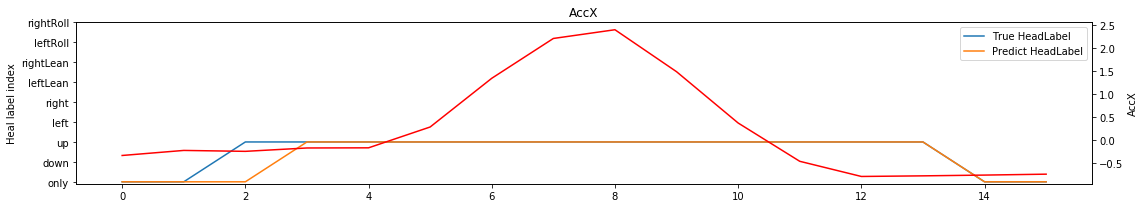

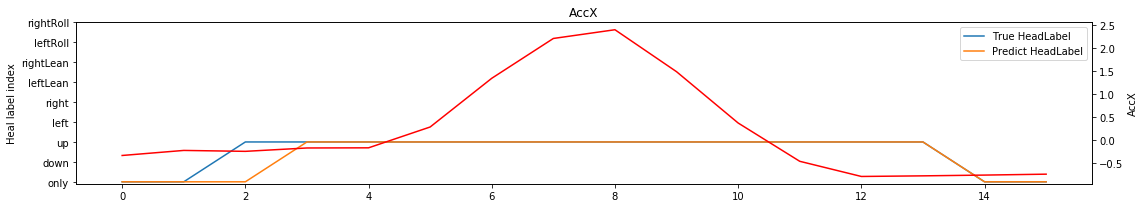

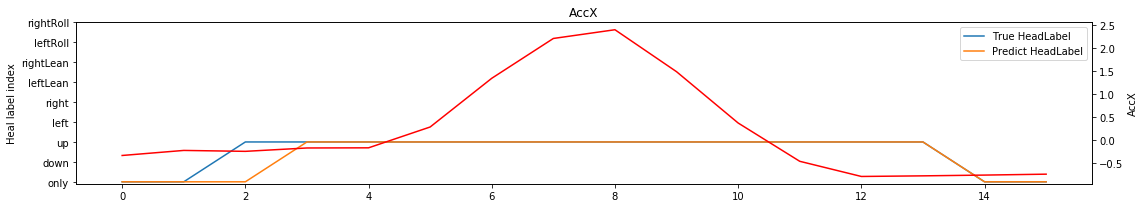

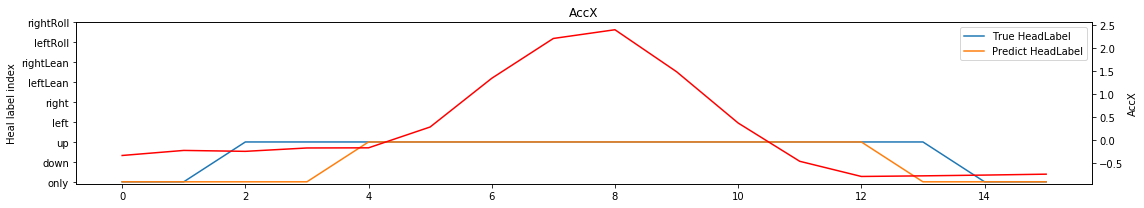

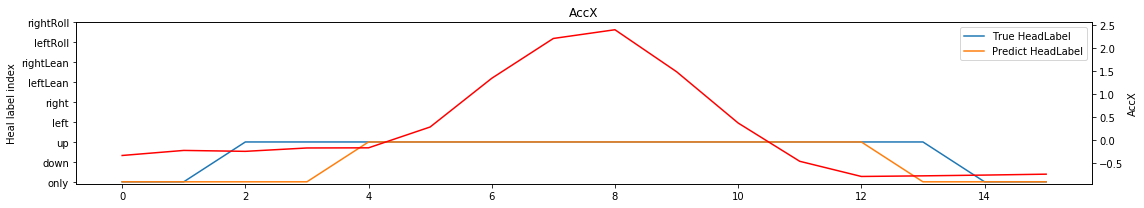

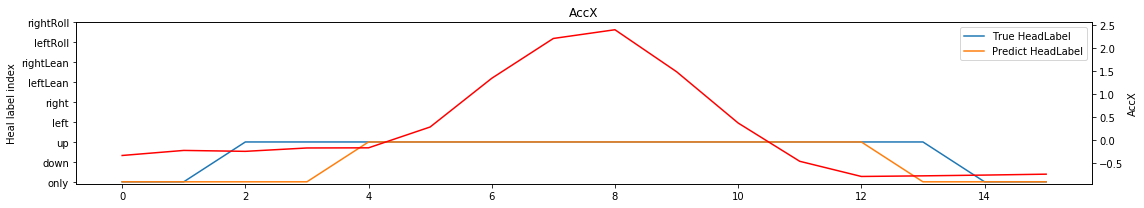

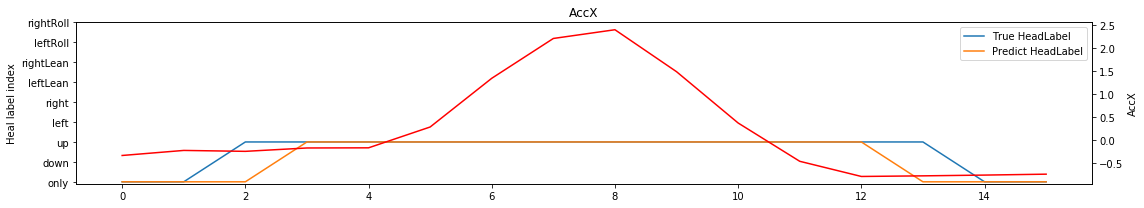

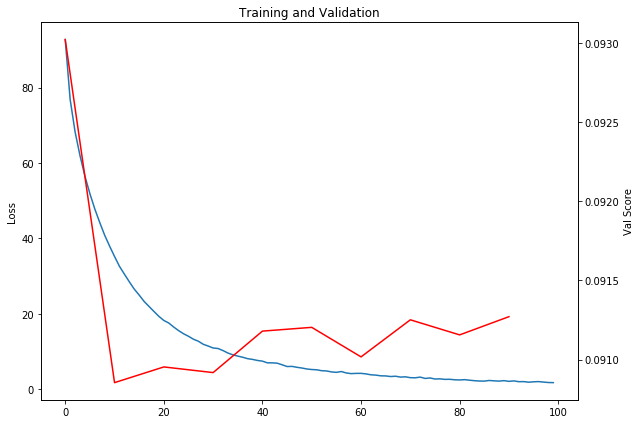

In [17]:
def eval_net(net, loader, device, n_val, thres):
    net.eval()
    tot = 0.

    for batch in loader:
        inputs = batch['inputs']
        headLabel = batch['headLabel']
        isWalk = batch['isWalk']
        inputs = inputs.to(device=device, dtype=torch.float32)
        headLabel = headLabel.to(device=device, dtype=torch.long)
        isWalk = isWalk.to(device=device, dtype=torch.long)
        
        headLabel_logits = net(inputs)

        for true_label, pred_logit in zip(headLabel, headLabel_logits):
            _, pred = pred_logit.max(dim=0)
            pred = F.one_hot(pred.T, 9).float()
            tot += F.cross_entropy(pred, true_label) / true_label.size()[0]
             
    tot = (tot / n_val).item()
    return tot

def plot_result(net, data, device, epoch):
    net.eval()
    
    inputs = data['inputs'].unsqueeze(dim=0)
    headLabel = data['headLabel']
    isWalk = data['isWalk']
    inputs = inputs.to(device=device, dtype=torch.float32)
    headLabel = headLabel.to(device=device, dtype=torch.long)
    isWalk = isWalk.to(device=device, dtype=torch.long)
    
    headLabel_logits = net(inputs).squeeze(dim=0)
    
    _, pred_label = headLabel_logits.max(dim=0)
    
    fig, ax1 = plt.subplots(figsize=(16, 3))
    
    inputs = inputs.numpy()[0]
    headLabel = headLabel.numpy()
    pred_label = pred_label.numpy()
    
    col_name = 'AccX'
    ax1.plot(range(headLabel.shape[0]), headLabel, label='True HeadLabel')
    ax1.set_ylabel('Heal label index')
    ax1.plot(range(headLabel.shape[0]), pred_label, label='Predict HeadLabel')
    ax1.legend()
    ax1.set_yticks(range(headLabel_logits.size()[0]))
    ax1.set_yticklabels([inverse_label_map[i] for i in range(headLabel_logits.size()[0])])

    ax2 = ax1.twinx()
    ax2.plot(range(headLabel.shape[0]), inputs[0, :], color='red')
    ax2.set_ylabel(col_name)
    # ax1.set_xlim([0, 40])
#     ax1.set_xticks(np.arange(0, len(data), 10))
    plt.title('{}'.format(col_name, gesture))
    plt.tight_layout()
    plt.savefig('outputs/dense_head_no_walk_epoch_{}'.format(epoch+1))

def train(dataloaders, datasets, epochs, batch_size, lr, thres, idx):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    n_val = len(datasets['test'])
    n_train = len(datasets['train'])

    headNet = DL(n_channels=6, n_classes=9).to(device=device)

    headLabel_criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(headNet.parameters(), lr=lr, weight_decay=1e-8)
    
    loss_list = []
    val_list = []
    for epoch in range(epochs):
        headNet.train()
    #     walkNet.train()

        epoch_loss = 0

        for batch in dataloaders['train']:
            inputs = batch['inputs']
            headLabel = batch['headLabel']
            isWalk = batch['isWalk']
            inputs = inputs.to(device=device, dtype=torch.float32)
            headLabel = headLabel.to(device=device, dtype=torch.long)
            isWalk = isWalk.to(device=device, dtype=torch.long)

            headLabel_logits = headNet(inputs)
#             print('headLabel_logits', headLabel_logits.size())
            loss = headLabel_criterion(headLabel_logits, headLabel)
            epoch_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
#             break
        loss_list.append(epoch_loss)
    
        if (epoch + 1) % 10 == 0:
            val_score = eval_net(headNet, dataloaders['test'], device, n_val, thres)
            print('epoch', epoch+1, 'epoch_loss', epoch_loss, 'val_score', val_score)
            val_list.append(val_score)
            
            plot_result(headNet, datasets['test'][idx], device, epoch)
            
    # plot
    fig, ax1 = plt.subplots(figsize=(9, 6))

    ax1.plot(range(epochs), loss_list)
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation')

    ax2 = ax1.twinx()
    ax2.plot(range(0, epochs, 10), val_list, color='red')
    ax2.set_ylabel('Val Score')
    plt.tight_layout()
    plt.savefig('outputs/dense_head_no_walk_loss.png', dpi=120)

epochs = 100
batch_size = 64
lr = 0.001
thres = 0.5
idx = 148

datasets = {
    x: HeadDataset('labeled_data/{}'.format(x)) for x in ['train', 'test']
}
dataloaders = {
    x: DataLoader(datasets[x], batch_size=batch_size, shuffle=True, num_workers=1) \
    for x in ['train', 'test']
}

train(dataloaders, datasets, epochs, batch_size, lr, thres, idx)